# Image recognition android application project
- Flower image classification with Baseline CNN (20200807)  

### Reference
- [coding-practice by **osterburg**], 'https://github.com/osterburg/coding-practice'

## 1. Import packages

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import tarfile
import glob
from six.moves import urllib
from glob import glob
import random
import shutil

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import load_model
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## 2. Load and Explore the Flower Dataset

In [12]:
def download_and_uncompress_tarball(tarball_url, dataset_dir):

    filename = tarball_url.split('/')[-1]
    filepath = os.path.join(dataset_dir, filename)

    def _progress(count, block_size, total_size):
        sys.stdout.write('\r>> Downloading %s %.1f%%' % (
            filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()

    filepath, _ = urllib.request.urlretrieve(tarball_url, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(dataset_dir)

In [13]:
# The URL where the Flowers data can be downloaded.
DATA_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
BASE_DIR = "dataset"

In [14]:
download_and_uncompress_tarball(DATA_URL, BASE_DIR)

>> Downloading flower_photos.tgz 100.0%
Successfully downloaded flower_photos.tgz 228813984 bytes.


In [15]:
def load_data_files(base_dir):
    folder_name = "dataset/flower_photos"
    RAW_DATASET = os.path.join(base_dir, folder_name)

    abs_dir = os.path.join(os.getcwd(), folder_name)
    sub_dir = os.listdir(abs_dir)
    data_dic = {}
    
    for class_name  in sub_dir:
        imgs = glob(os.path.join(RAW_DATASET,class_name,"*.jpg"))

        data_dic[class_name] = imgs
        print("Class: {}".format(class_name))
        print("Number of images: {} \n".format(len(imgs)))

    return data_dic

In [19]:
BASE_DIR = os.getcwd()
data_dic = load_data_files(BASE_DIR)

Class: daisy
Number of images: 633 

Class: dandelion
Number of images: 898 

Class: roses
Number of images: 641 

Class: sunflowers
Number of images: 699 

Class: tulips
Number of images: 799 



In [20]:
def plot_image_grid(images_files):
    # figure size
    fig = plt.figure(figsize=(8, 8))

    # load images
    images = [tf.keras.preprocessing.image.load_img(img) for img in images_files]

    # plot image grid
    for x in range(4):
        for y in range(4):
            ax = fig.add_subplot(4, 4, 4*y+x+1)
            plt.imshow(images[4*y+x])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

Flower type: daisy


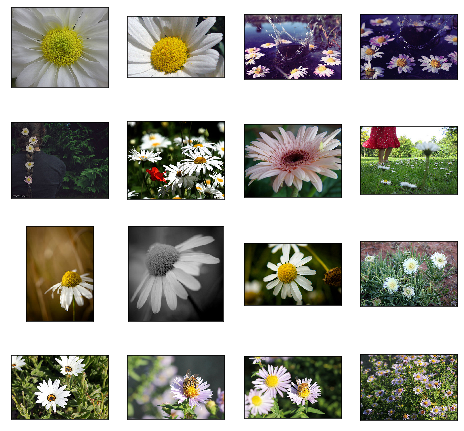

Flower type: dandelion


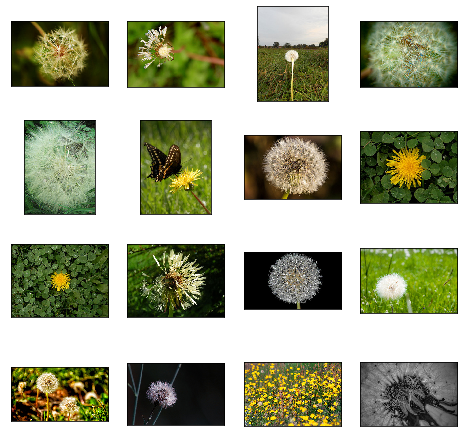

Flower type: roses


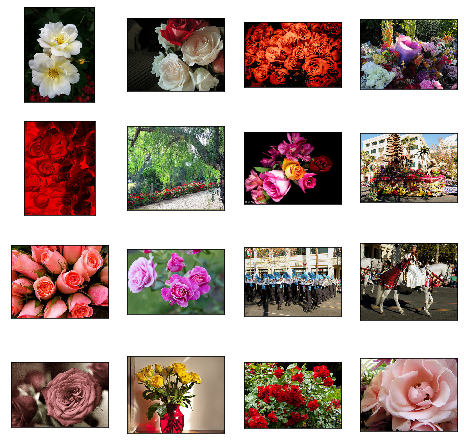

Flower type: sunflowers


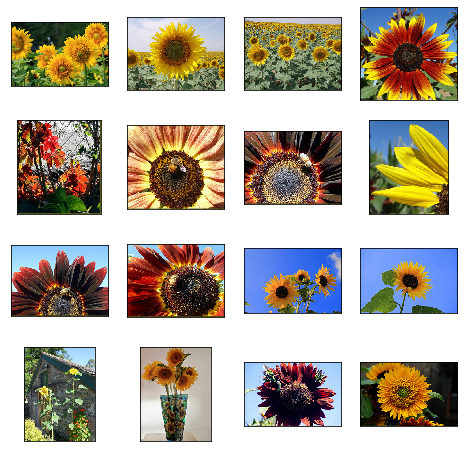

Flower type: tulips


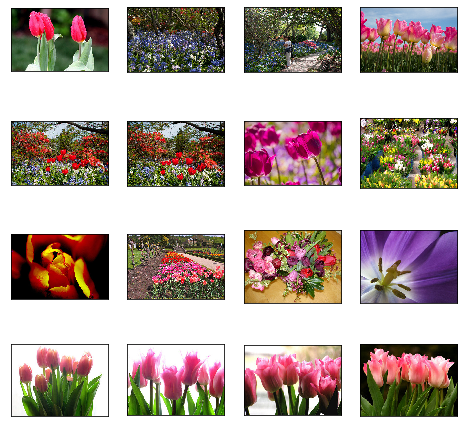

In [21]:
for class_name, imgs in data_dic.items():
    print("Flower type: {}".format(class_name))
    plot_image_grid(imgs[:16])

## 3. Split train and validation dataset

In [27]:
# Create new directory and copy files to it
def copy_files_to_directory(files, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created directory: {}".format(directory))

    for f in files:
        shutil.copy(f, directory)
    print("Copied {} files.\n".format(len(files)))

In [28]:
def train_validation_split(base_dir, data_dic, split_ratio=0.2):
    FLOWER_DATASET = os.path.join(base_dir,"flower_dataset")

    if not os.path.exists(FLOWER_DATASET):
        os.makedirs(FLOWER_DATASET)

    for class_name, imgs in data_dic.items():
        idx_split = int(len(imgs) * split_ratio)
        random.shuffle(imgs)
        validation = imgs[:idx_split]
        train = imgs[idx_split:]

        copy_files_to_directory(train, os.path.join(FLOWER_DATASET,"train",class_name))
        copy_files_to_directory(validation, os.path.join(FLOWER_DATASET,"validation",class_name))

In [29]:
BASE_DIR = os.getcwd()

train_validation_split(BASE_DIR, data_dic, split_ratio=0.2)

Created directory: C:\Users\오서영\Desktop\스터디\20200807_baseline_code\flower_dataset\train\daisy
Copied 507 files.

Created directory: C:\Users\오서영\Desktop\스터디\20200807_baseline_code\flower_dataset\validation\daisy
Copied 126 files.

Created directory: C:\Users\오서영\Desktop\스터디\20200807_baseline_code\flower_dataset\train\dandelion
Copied 719 files.

Created directory: C:\Users\오서영\Desktop\스터디\20200807_baseline_code\flower_dataset\validation\dandelion
Copied 179 files.

Created directory: C:\Users\오서영\Desktop\스터디\20200807_baseline_code\flower_dataset\train\roses
Copied 513 files.

Created directory: C:\Users\오서영\Desktop\스터디\20200807_baseline_code\flower_dataset\validation\roses
Copied 128 files.

Created directory: C:\Users\오서영\Desktop\스터디\20200807_baseline_code\flower_dataset\train\sunflowers
Copied 560 files.

Created directory: C:\Users\오서영\Desktop\스터디\20200807_baseline_code\flower_dataset\validation\sunflowers
Copied 139 files.

Created directory: C:\Users\오서영\Desktop\스터디\20200807_basel

## 4. Image preprocessing

In [31]:
preprocessing_image = tf.keras.preprocessing.image

train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [32]:
BASE_DIR = os.getcwd()

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "flower_dataset/train"),
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "flower_dataset/validation"),
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


## 5. Baseline CNN model

In [33]:
batch_size = 64
num_classes = 5
epochs = 50

In [116]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)             

In [39]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=adam(lr=0.0005), metrics=['accuracy'])

## 6. Training

In [125]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/50
100/100 [==============================] - 15s 151ms/step - loss: 1.1096 - accuracy: 0.5562 - val_loss: 1.0722 - val_accuracy: 0.5641
Epoch 2/50
100/100 [==============================] - 15s 150ms/step - loss: 1.1079 - accuracy: 0.5584 - val_loss: 0.8723 - val_accuracy: 0.5496
Epoch 3/50
100/100 [==============================] - 15s 145ms/step - loss: 1.0794 - accuracy: 0.5684 - val_loss: 0.9584 - val_accuracy: 0.5575
Epoch 4/50
100/100 [==============================] - 14s 141ms/step - loss: 1.0716 - accuracy: 0.5793 - val_loss: 1.1696 - val_accuracy: 0.5465
Epoch 5/50
100/100 [==============================] - 14s 136ms/step - loss: 1.0560 - accuracy: 0.5746 - val_loss: 1.1473 - val_accuracy: 0.6079
Epoch 6/50
100/100 [==============================] - 14s 137ms/step - loss: 1.0577 - accuracy: 0.5822 - val_loss: 1.1096 - val_accuracy: 0.5496
Epoch 7/50
100/100 [==============================] - 14s 142ms/step - loss: 1.0357 - accuracy: 0.5890 - val_loss: 0.9358 - val_ac

## 7. Accuracy Analysis and Visualization

In [126]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Baseline CNN Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Baseline CNN loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

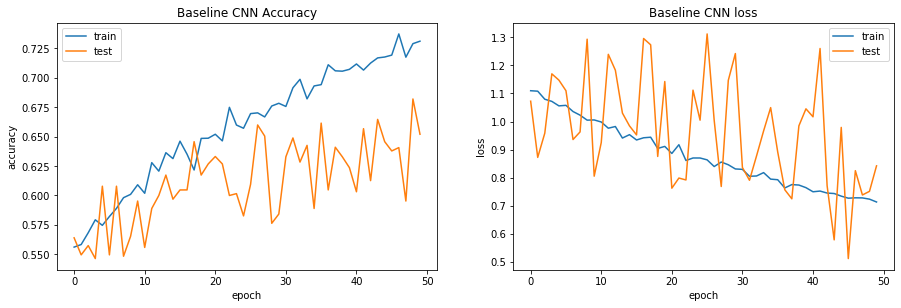

In [127]:
plot_accuracy_and_loss(history)

In [40]:
print("-- Evaluate --")

scores_train = model.evaluate_generator(
            train_generator, 
            steps = 5)
scores_val = model.evaluate_generator(
            validation_generator, 
            steps = 5)

print("%s: %.2f%%" %(model.metrics_names[1], scores_train[1]*100))
print("%s: %.2f%%" %(model.metrics_names[1], scores_val[1]*100))

print("-- Predict --")
output_train = model.predict_generator(train_generator, steps=5)
output_val = model.predict_generator(validation_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(train_generator.class_indices)
print(output_train)

print(validation_generator.class_indices)
print(output_val)

-- Evaluate --
accuracy: 72.50%
accuracy: 76.88%
-- Predict --
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
[[0.017 0.022 0.042 0.378 0.542]
 [0.008 0.032 0.004 0.864 0.092]
 [0.000 0.000 0.864 0.000 0.136]
 [0.005 0.000 0.702 0.004 0.289]
 [0.435 0.404 0.080 0.023 0.058]
 [0.002 0.079 0.128 0.198 0.594]
 [0.009 0.033 0.230 0.261 0.468]
 [0.109 0.172 0.011 0.342 0.367]
 [0.041 0.951 0.001 0.001 0.006]
 [0.209 0.001 0.620 0.000 0.170]
 [0.075 0.239 0.013 0.416 0.257]
 [0.175 0.459 0.068 0.057 0.241]
 [0.061 0.479 0.321 0.004 0.135]
 [0.076 0.642 0.167 0.039 0.075]
 [0.007 0.945 0.040 0.000 0.009]
 [0.157 0.611 0.045 0.021 0.166]
 [0.576 0.372 0.024 0.002 0.027]
 [0.052 0.863 0.041 0.009 0.036]
 [0.010 0.000 0.794 0.000 0.196]
 [0.001 0.045 0.007 0.920 0.028]
 [0.095 0.151 0.027 0.720 0.007]
 [0.118 0.090 0.353 0.027 0.412]
 [0.037 0.052 0.631 0.024 0.256]
 [0.030 0.789 0.158 0.003 0.019]
 [0.137 0.701 0.070 0.022 0.070]
 [0.275 0.255 0.378 0.014 0.077]
 [0.007 

## 8. Save and Load model

In [135]:
# save model architecture
model_json = model.to_json()
open('baseline_cnn_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('baseline_cnn_weights.h5', overwrite=True)

In [36]:
# Load trained model
from keras.models import model_from_json 

json_file = open("baseline_cnn_model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
loaded_model.load_weights("baseline_cnn_weights.h5")
print("Loaded model from disk")

Loaded model from disk
